# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [6]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200820/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200921/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200924/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200925/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/'

os.system("mkdir -p "+ plotDir)

0

# Signal part

In [42]:
masses = np.array([127, 150, 175, 200, 250, 300, 400])
# masses = np.array([ 200 ])


# directory
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v13/MC_Fall17/normalized/'
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v14/MC_Fall17/normalized/'
# home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v16/MC_Fall17/normalized/'
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v17/MC_Fall17/normalized/'
# file names
fnames = {}
# get all the trees
tree = OrderedDict()

for mass in masses:
    fnames[str(mass)] = 'n3n2-n1-hbb-hbb_mh'+str(mass)+'_pl1000_ev100000_1pb_weighted.root'
#     fnames[str(mass)] = 'n3n2-n1-hbb-hbb_mh'+str(mass)+'_pl10000_ev100000_1pb_weighted.root'

    print(home_dir+fnames[str(mass)])

    root_dir = uproot.open(home_dir+fnames[str(mass)])
    tree[str(mass)] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(mass)
    print ('Tree ready')
    print(tree[str(mass)], tree)
    v = tree[str(mass)]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v17/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh127_pl1000_ev100000_1pb_weighted.root
Open ready
127
Tree ready
<TTree b'SusyLLPTree' at 0x7fa39935fc88> OrderedDict([('127', <TTree b'SusyLLPTree' at 0x7fa39935fc88>)])
[[0.43065673 0.47074464 0.28370467 0.43933094] [] [0.028899437] ... [] [0.5910178 0.0054660393 0.026043097] [0.45760188]]
[5.6951445e-05 5.6951445e-05 5.6951445e-05 5.6951445e-05 5.6951445e-05
 5.6951445e-05 5.6951445e-05 5.6951445e-05 5.6951445e-05 5.6951445e-05]
[5.6951445e-05]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v17/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh150_pl1000_ev100000_1pb_weighted.root
Open ready
150
Tree ready
<TTree b'SusyLLPTree' at 0x7fa39915d0b8> OrderedDict([('127', <TTree b'SusyLLPTree' at 0x7fa39935fc88>), ('150', <TTree b'SusyLLPTree' at 0x7fa39915d0b8>)])
[[0.007690436] [0.2964583 0.026690569 0.4548747] [0.0068501025 0.13449997 0.69

In [43]:
for k,v in tree.items():
    print(k,v)

127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>


# 0 lep region

In [44]:
# trg_path=310
trg_path=467
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

fatjet=0
fatjet_pt_cut=0
# fatjet_pt_cut=250
# fatjet_pt_cut=300

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 
trg_jet_puw = {} 

trg_llp_dau_id = {}
trg_llp_dau_pt = {}
trg_llp_dau_eta = {}
trg_llp_dau_phi = {}
trg_llp_dau_dr = {}
trg_llp_dau_dr_ak8 = {}

trg_llp_grandau_id = {}
trg_llp_grandau_pt = {}
trg_llp_grandau_eta = {}
trg_llp_grandau_phi = {}
trg_llp_grandau_dr = {}

trg_fatjet_pt = {}
trg_fatjet_eta = {}

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}

trg_jet_csv = {}

jet_csv_cut=0.5803
trg_jet_csvl = {}
trg_jet_nb = {}

ECAL_R=129.0 #cm
EB_Z=268.3 #cm
trg_jet_ctau = {}
trg_jet_eb = {}
trg_jet_tagged = {}

for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
#     llp_r = v['gLLP_decay_vertex_r'].array()
#     llp_z = v['gLLP_decay_vertex_z'].array()
    llp_tagged = v['gLLP_tagged'].array()
    llp_eb = v['gLLP_eb'].array()
    llp_ctau = v['gLLP_ctau'].array()
    
    llp_dau_id = v['gLLP_daughter_id'].array()
    llp_dau_pt = v['gLLP_daughter_pt'].array()
    llp_dau_eta = v['gLLP_daughter_eta'].array()
    llp_dau_eta_corr = v['gLLP_daughter_eta_ecalcorr'].array()
    llp_dau_phi = v['gLLP_daughter_phi'].array()
    llp_dau_phi_corr = v['gLLP_daughter_phi_ecalcorr'].array()
    llp_dau_mindr = v['gLLP_daughter_min_delta_r_match_jet'].array()
    llp_dau_mindr_ak8 = v['gLLP_daughter_min_delta_r_match_fatjet'].array()

    
    llp_grandau_id = v['gLLP_grandaughter_id'].array()
    llp_grandau_pt = v['gLLP_grandaughter_pt'].array()
    llp_grandau_eta = v['gLLP_grandaughter_eta'].array()
    llp_grandau_eta_corr = v['gLLP_grandaughter_eta_ecalcorr'].array()
    llp_grandau_phi = v['gLLP_grandaughter_phi'].array()
    llp_grandau_phi_corr = v['gLLP_grandaughter_phi_ecalcorr'].array()
    llp_grandau_mindr = v['gLLP_grandaughter_min_delta_r_match_jet'].array()

#     
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    fatpt = v['fatJetPt'].array()
    fateta = v['fatJetEta'].array()
    
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()
    
    csv = v['jetCSV'].array()

    weight = v['weight'].array()
    
    #pileup weights
#     if 'background' in k:
    if 'Data' not in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)  
    
    basic_fatjet_str = np.logical_and(abs(fateta)<jet_eta_cut, fatpt>jet_pt_cut) 
    
#     basic_llp_dau_str = np.logical_and(abs(llp_dau_eta)<jet_eta_cut, llp_dau_pt>jet_pt_cut)   
#     basic_llp_grandau_str = np.logical_and(abs(llp_grandau_eta)<jet_eta_cut, llp_grandau_pt>jet_pt_cut)  
    
#     basic_llp_dau_str = np.logical_and(abs(llp_dau_eta_corr)<jet_eta_cut, llp_dau_pt>0)   
#     basic_llp_dau_str = np.logical_and(abs(llp_dau_id)==25, basic_llp_dau_str) 
    
#     basic_llp_grandau_str = np.logical_and(abs(llp_grandau_eta_corr)<jet_eta_cut, llp_grandau_pt>0)   
#     basic_llp_grandau_str = np.logical_and(abs(llp_grandau_id)==5, basic_llp_grandau_str) 

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
    
#     print(fatpt[fatpt>fatjet_pt_cut].count()[:10])
#     print(fatpt[:10])
#     print(fatpt[fatpt>fatjet_pt_cut][:10])
#     fatjet_str = np.logical_and(1, fatpt[fatpt>fatjet_pt_cut].count()==0)
    fatjet_str = np.logical_and(1, fatpt[fatpt>fatjet_pt_cut].count()>0)
    if fatjet:
        met_trg_str = np.logical_and(basic_met_str, fatjet_str)
#     if 'H(bb)' in k:
#         met_trg_str = np.logical_and(basic_met_str, np.sum(llp_eb,axis = 1) > 0) 

    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = PUweight[met_trg_str]
    trg_jet_ctau[k] = llp_ctau[met_trg_str]
    trg_jet_eb[k] = llp_eb[met_trg_str]
    trg_jet_tagged[k] = llp_tagged[met_trg_str]
        

    trg_llp_dau_id[k] = llp_dau_id[met_trg_str]
    trg_llp_dau_pt[k] = llp_dau_pt[met_trg_str]
    trg_llp_dau_eta[k] = llp_dau_eta_corr[met_trg_str]
    trg_llp_dau_phi[k] = llp_dau_phi_corr[met_trg_str]
    trg_llp_dau_dr[k] = llp_dau_mindr[met_trg_str]
    trg_llp_dau_dr_ak8[k] = llp_dau_mindr_ak8[met_trg_str]
    
    trg_llp_grandau_id[k] = llp_grandau_id[met_trg_str]
    trg_llp_grandau_pt[k] = llp_grandau_pt[met_trg_str]
    trg_llp_grandau_eta[k] = llp_grandau_eta_corr[met_trg_str]
    trg_llp_grandau_phi[k] = llp_grandau_phi_corr[met_trg_str]
    trg_llp_grandau_dr[k] = llp_grandau_mindr[met_trg_str]
    
#     trg_llp_dau_pt[k] = llp_dau_pt[basic_llp_dau_str][met_trg_str]
#     trg_llp_dau_eta[k] = llp_dau_eta_corr[basic_llp_dau_str][met_trg_str]
#     trg_llp_dau_phi[k] = llp_dau_phi_corr[basic_llp_dau_str][met_trg_str]
#     trg_llp_dau_dr[k] = llp_dau_mindr[basic_llp_dau_str][met_trg_str]
#     trg_llp_dau_dr_ak8[k] = llp_dau_mindr_ak8[basic_llp_dau_str][met_trg_str]
    
#     trg_llp_grandau_pt[k] = llp_grandau_pt[basic_llp_grandau_str][met_trg_str]
#     trg_llp_grandau_eta[k] = llp_grandau_eta_corr[basic_llp_grandau_str][met_trg_str]
#     trg_llp_grandau_phi[k] = llp_grandau_phi_corr[basic_llp_grandau_str][met_trg_str]
#     trg_llp_grandau_dr[k] = llp_grandau_mindr[basic_llp_grandau_str][met_trg_str]
    
    trg_fatjet_pt[k] = fatpt[basic_fatjet_str][met_trg_str]
    trg_fatjet_eta[k] = fatpt[basic_fatjet_str][met_trg_str]
    

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]

    #clean up
#     clean_up_str = np.logical_and(trg_jet_pt[k].count()>njet_cut, trg_fatjet_pt[k][trg_fatjet_pt[k]>fatjet_pt_cut].count()==0)
    clean_up_str = np.logical_and(trg_jet_pt[k].count()>njet_cut, 1)
    
    trg_jet_met[k] = trg_jet_met[k][clean_up_str]
    trg_jet_ht[k] = trg_jet_ht[k][clean_up_str]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][clean_up_str]
    trg_jet_nj[k] = trg_jet_nj[k][clean_up_str]
    trg_jet_w[k] = trg_jet_w[k][clean_up_str]
    
    trg_llp_dau_id[k] = trg_llp_dau_id[k][clean_up_str]
    trg_llp_dau_pt[k] = trg_llp_dau_pt[k][clean_up_str]
    trg_llp_dau_eta[k] = trg_llp_dau_eta[k][clean_up_str]
    trg_llp_dau_phi[k] = trg_llp_dau_phi[k][clean_up_str]
    trg_llp_dau_dr[k] = trg_llp_dau_dr[k][clean_up_str]
    trg_llp_dau_dr_ak8[k] = trg_llp_dau_dr_ak8[k][clean_up_str]
    
    trg_llp_grandau_id[k] = trg_llp_grandau_id[k][clean_up_str]
    trg_llp_grandau_pt[k] = trg_llp_grandau_pt[k][clean_up_str]
    trg_llp_grandau_eta[k] = trg_llp_grandau_eta[k][clean_up_str]
    trg_llp_grandau_phi[k] = trg_llp_grandau_phi[k][clean_up_str]
    trg_llp_grandau_dr[k] = trg_llp_grandau_dr[k][clean_up_str]
    
#     if 'background' in k:
    if 'Data' not in k:
        trg_jet_puw[k] = trg_jet_puw[k][clean_up_str]
    trg_jet_ctau[k] = trg_jet_ctau[k][clean_up_str]
    trg_jet_eb[k] = trg_jet_eb[k][clean_up_str]
    trg_jet_tagged[k] = trg_jet_tagged[k][clean_up_str]

    trg_jet_phi[k] = trg_jet_phi[k][clean_up_str]
    trg_jet_eta[k] = trg_jet_eta[k][clean_up_str]
    trg_jet_e[k] = trg_jet_e[k][clean_up_str]

#     trg_jet_nhm[k] = trg_jet_nhm[k][clean_up_str]
#     trg_jet_chm[k] = trg_jet_chm[k][clean_up_str]
#     trg_jet_mum[k] = trg_jet_mum[k][clean_up_str]
#     trg_jet_elem[k] = trg_jet_elem[k][clean_up_str]
#     trg_jet_phom[k] = trg_jet_phom[k][clean_up_str]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][clean_up_str]
    trg_jet_chef[k] = trg_jet_chef[k][clean_up_str]
    trg_jet_muef[k] = trg_jet_muef[k][clean_up_str]
    trg_jet_eleef[k] = trg_jet_eleef[k][clean_up_str]
    trg_jet_phoef[k] = trg_jet_phoef[k][clean_up_str]
    
#     trg_jet_csv[k] = trg_jet_csv[k][clean_up_str]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][clean_up_str]
    trg_jet_time[k] = trg_jet_time[k][clean_up_str]
    trg_jet_dr[k] = trg_jet_dr[k][clean_up_str]
    trg_jet_tmf[k] = trg_jet_tmf[k][clean_up_str]
#     trg_jet_amax[k] = trg_jet_amax[k][clean_up_str]

    trg_jet_csv[k] = trg_jet_csv[k][clean_up_str]
    trg_jet_csvl[k] = trg_jet_csv[k][trg_jet_csv[k]>jet_csv_cut]
    trg_jet_nb[k] = trg_jet_csvl[k].count()

    trg_jet_pt[k] = trg_jet_pt[k][clean_up_str]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_puw[k]))
    print(len(trg_llp_dau_pt[k]))
    print(len(trg_llp_grandau_pt[k]))
    print(len(trg_jet_pt[k]))
    print(len(trg_jet_ctau[k]))
    print(len(trg_jet_eb[k]))
    print(len(trg_jet_tagged[k]))
    print(len(trg_fatjet_pt[k]))
    
#     print(trg_jet_ctau[k][:10])
#     print(trg_jet_pt[k][:10])
#     print(trg_llp_dau_pt[k][:10])
#     print(trg_llp_grandau_pt[k][:10])
#     print(trg_fatjet_pt[k][:10])
#     print(trg_jet_eb[k][:10])

    

127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
(2756,)
2415
2415
2415
2415
2415
2415
2415
2415
2415
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
(2908,)
2522
2522
2522
2522
2522
2522
2522
2522
2522
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
(3011,)
2586
2586
2586
2586
2586
2586
2586
2586
2586
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
(3595,)
3021
3021
3021
3021
3021
3021
3021
3021
3021
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
(5201,)
4282
4282
4282
4282
4282
4282
4282
4282
4282
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
(7429,)
6145
6145
6145
6145
6145
6145
6145
6145
6145
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
(13315,)
10994
10994
10994
10994
10994
10994
10994
10994
10994


# Gen Study

In [45]:
variables = [
    [2, trg_llp_dau_pt, 40, 0, 2000, 'H Pt [GeV]', 'llp_dau_pt', 25],
    [2, trg_llp_dau_eta, 40, -5, 5, 'H Eta', 'llp_dau_eta', 25],
    [2, trg_llp_dau_phi, 40, -3.15, 3.15, 'H Phi', 'llp_dau_phi', 25],
    [2, trg_llp_dau_dr, 40, 0, 0.8, 'minDeltaR(H, AK4)', 'llp_dau_mindr', 25],
    [2, trg_llp_dau_dr_ak8, 40, 0, 0.8, 'minDeltaR(H, AK8)', 'llp_dau_mindr_ak8', 25],
]

In [46]:
fatjet_pt_cut=0
# fatjet_pt_cut=250
# fat_jet_pt_cut=300

plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/'+str(fatjet_pt_cut)+'/'

os.system("mkdir -p "+ plotDir)

0

In [47]:
# print(len(trg_llp_dau_pt[k][0]))
# print(len(trg_llp_dau_pt[k]))
# print(len(trg_llp_dau_pt[k][abs(trg_llp_dau_id[k])==var[7]]))


H Pt [GeV]
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
4830
4830
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
5044
5044
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
5172
5172
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
6042
6042
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
8564
8564
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
12290
12290
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
21988
21988
400 43
137.0 fb^{-1} (13 TeV)
H Eta
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
4830
4830
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
5044
5044
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
5172
5172
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
6042
6042
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
8564
8564
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
12290
12290
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
21988
21988
400 43
137.0 fb^{-1} (13 TeV)
H Phi
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
4830
4830
127 1
150 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_dau_pt_fatjet0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_dau_eta_fatjet0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_dau_phi_fatjet0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_dau_mindr_fatjet0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_dau_mi

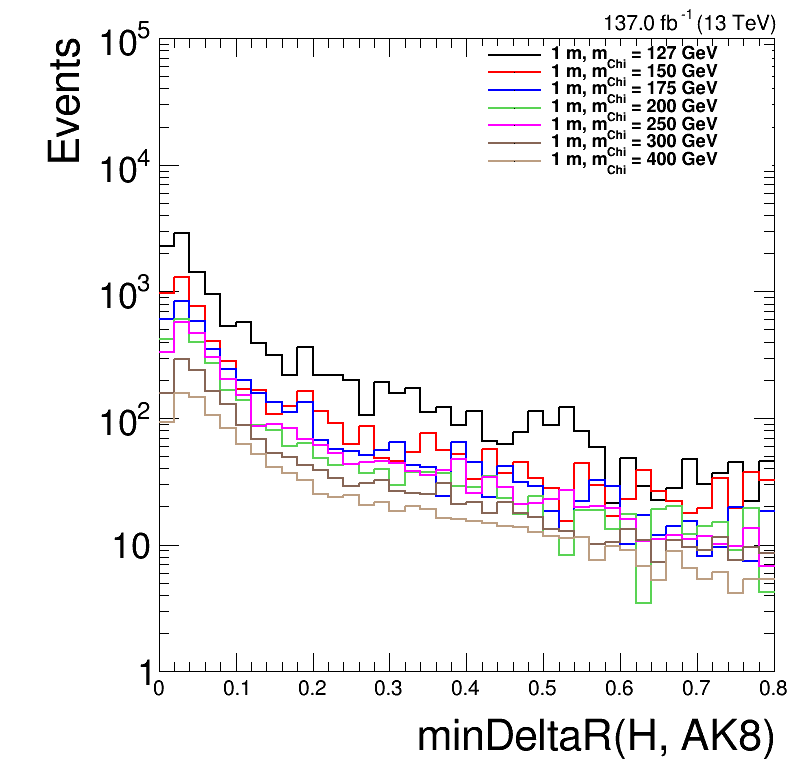

In [48]:
# Plotting 
lumi=137000
color_list = [845,806,861,876,597,625]

for var in variables:
    print(var[5])
    axis_set = [var[5], 'Events']
    bin_set = [var[2],var[3],var[4]]
#     outf = var[6]+'.png'
    outf = var[6]+'_fatjet'+str(fatjet_pt_cut)+'.png'
    
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.60,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)



    i=0
    for k,v in tree.items():
        print(k,v)

#         sel_str = np.logical_and(abs(trg_llp_dau_id[k])==var[7], trg_llp_dau_pt[k]>fatjet_pt_cut)
        sel_str = np.logical_and(abs(trg_llp_dau_id[k])==var[7], 1)
        plt_var = var[1][k][sel_str] 
        ws = trg_jet_w[k]*trg_jet_puw[k]
        ws = np.array([[x,x] for x in ws])
        ws = ws.flatten()
        print(len(plt_var))
        print(len(ws))

        ht[k] = create_TH1D( plt_var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+5)
        print(k, std_color_list[i])
        ht[k].Draw("hist same")
        leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  

        i+=1

    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)

    leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)    


H Pt [GeV]
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
400 43
137.0 fb^{-1} (13 TeV)
H Eta
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
400 43
137.0 fb^{-1} (13 TeV)
H Phi
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
200 8
250 <TTre

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_dau_pt_fatjet0_shape.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_dau_eta_fatjet0_shape.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_dau_phi_fatjet0_shape.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_dau_mindr_fatjet0_shape.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201

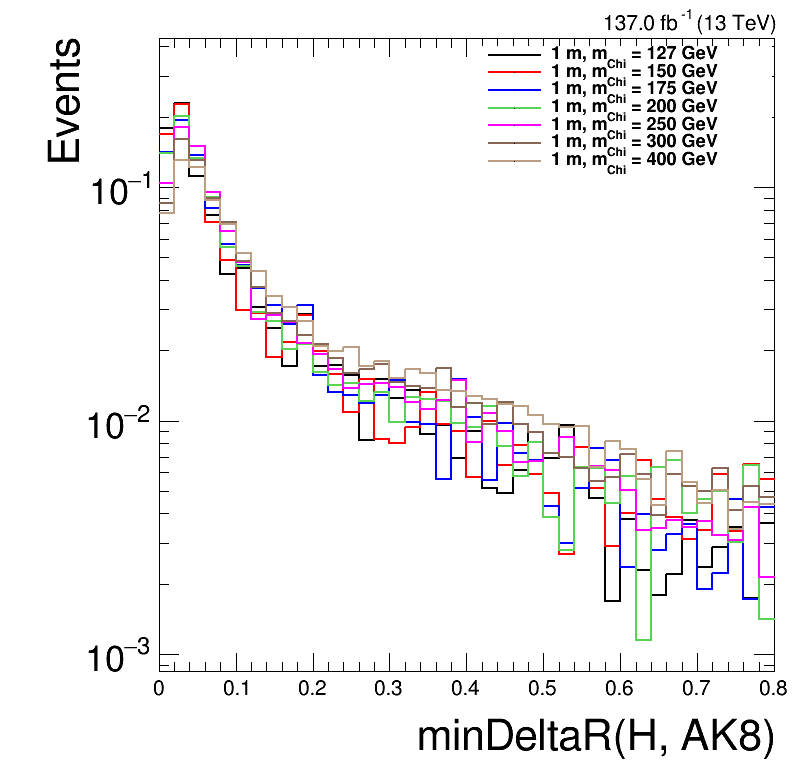

In [49]:
# Plotting 
lumi=137000
color_list = [845,806,861,876,597,625]

for var in variables:
    print(var[5])
    axis_set = [var[5], 'Events']
    bin_set = [var[2],var[3],var[4]]
#     outf = var[6]+'_shape.png'
    outf = var[6]+'_fatjet'+str(fatjet_pt_cut)+'_shape.png'
    
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.60,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)



    i=0
    for k,v in tree.items():
        print(k,v)

        plt_var = var[1][k][abs(trg_llp_dau_id[k])==var[7]] 
        ws = trg_jet_w[k]*trg_jet_puw[k]
        ws = np.array([[x,x] for x in ws])
        ws = ws.flatten()
#         print(len(ws))

        ht[k] = create_TH1D( plt_var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
#         ht[k].GetYaxis().SetRangeUser(1e-5,0.5)
        print(k, std_color_list[i])
        ht[k].DrawNormalized("hist same")
        leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  

        i+=1

    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)

    leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)    


In [50]:
variables = [
    [4, trg_llp_grandau_pt, 40, 0, 2000, 'b Pt [GeV]', 'llp_grandau_pt', 5],
    [4, trg_llp_grandau_eta, 40, -5, 5, 'b Eta', 'llp_grandau_eta', 5],
    [4, trg_llp_grandau_phi, 40, -3.15, 3.15, 'b Phi', 'llp_grandau_phi', 5],
    [4, trg_llp_grandau_dr, 40, 0, 0.8, 'minDeltaR(b, AK4)', 'llp_grandau_mindr', 25],
]

b Pt [GeV]
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
9660
9660
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
10088
10088
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
10344
10344
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
12084
12084
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
17128
17128
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
24580
24580
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
43976
43976
400 43
137.0 fb^{-1} (13 TeV)
b Eta
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
9660
9660
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
10088
10088
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
10344
10344
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
12084
12084
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
17128
17128
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
24580
24580
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
43976
43976
400 43
137.0 fb^{-1} (13 TeV)
b Phi
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
9660

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_pt_fatjet0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_eta_fatjet0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_phi_fatjet0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_mindr_fatjet0.png has been created


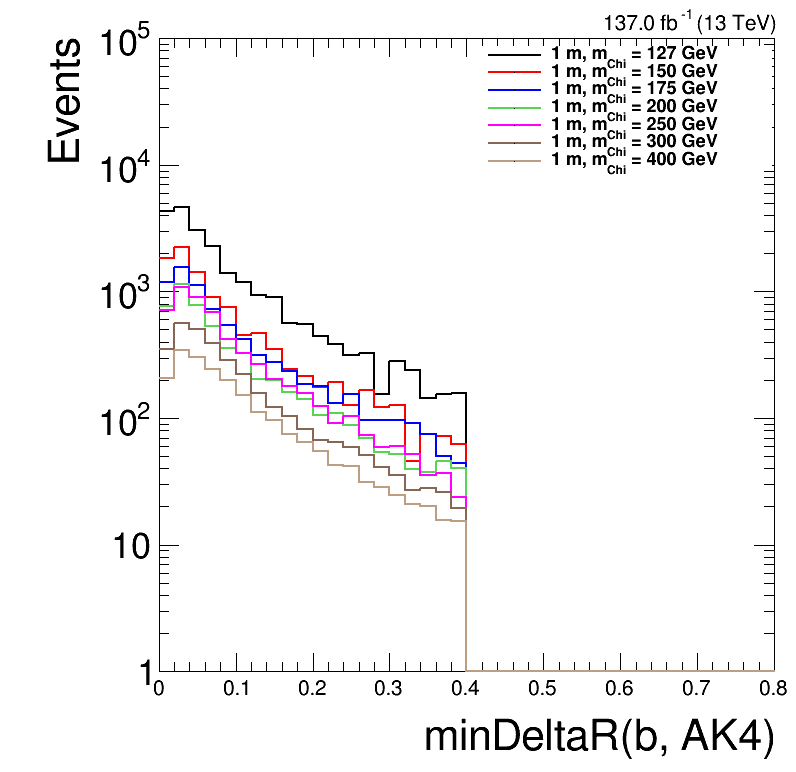

In [51]:
# Plotting 
lumi=137000
color_list = [845,806,861,876,597,625]

for var in variables:
    print(var[5])
    axis_set = [var[5], 'Events']
    bin_set = [var[2],var[3],var[4]]
#     outf = var[6]+'.png'
    outf = var[6]+'_fatjet'+str(fatjet_pt_cut)+'.png'
    
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.60,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)



    i=0
    for k,v in tree.items():
        print(k,v)

#         plt_var = var[1][k][abs(trg_llp_dau_id[k])==var[7]] 
        plt_var = var[1][k].flatten() 
        ws = trg_jet_w[k]*trg_jet_puw[k]
        ws = np.array([[x,x,x,x] for x in ws])
        ws = ws.flatten()
        print(len(ws))
        print(len(plt_var))

        ht[k] = create_TH1D( plt_var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
        ht[k].GetYaxis().SetRangeUser(1,1e+5)
        print(k, std_color_list[i])
        ht[k].Draw("hist same")
        leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  

        i+=1

    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)

    leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)    


b Pt [GeV]
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
9660
9660
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
10088
10088
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
10344
10344
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
12084
12084
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
17128
17128
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
24580
24580
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
43976
43976
400 43
137.0 fb^{-1} (13 TeV)
b Eta
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
9660
9660
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
10088
10088
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
10344
10344
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
12084
12084
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
17128
17128
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
24580
24580
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
43976
43976
400 43
137.0 fb^{-1} (13 TeV)
b Phi
127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
9660

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_pt_fatjet0_shape.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_eta_fatjet0_shape.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_phi_fatjet0_shape.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_mindr_fatjet0_shape.png has been created


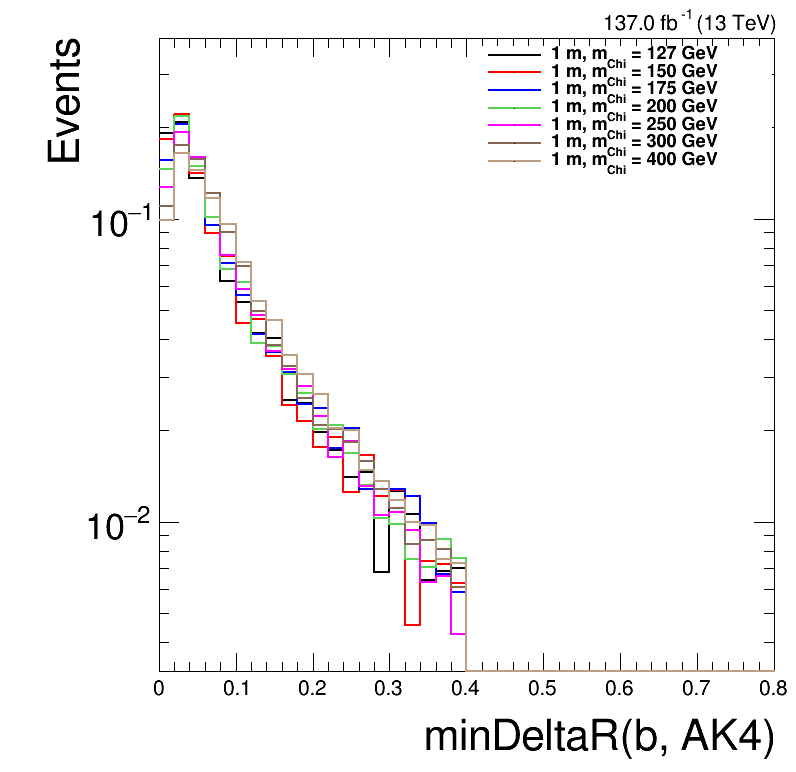

In [52]:
# Plotting 
lumi=137000
color_list = [845,806,861,876,597,625]

for var in variables:
    print(var[5])
    axis_set = [var[5], 'Events']
    bin_set = [var[2],var[3],var[4]]
#     outf = var[6]+'_shape.png'
    outf = var[6]+'_fatjet'+str(fatjet_pt_cut)+'_shape.png'
    
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.60,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)



    i=0
    for k,v in tree.items():
        print(k,v)

#         plt_var = var[1][k][abs(trg_llp_dau_id[k])==var[7]] 
        plt_var = var[1][k].flatten() 
        ws = trg_jet_w[k]*trg_jet_puw[k]
        ws = np.array([[x,x,x,x] for x in ws])
        ws = ws.flatten()
        print(len(ws))
        print(len(plt_var))

        ht[k] = create_TH1D( plt_var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
        ht[k].SetLineColor(std_color_list[i])
        ht[k].GetXaxis().SetLabelSize(0.03)
#         ht[k].GetYaxis().SetRangeUser(1,1e+5)
        print(k, std_color_list[i])
        ht[k].DrawNormalized("hist same")
        leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  

        i+=1

    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)

    leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.027)
    c.SetLogy()
    c.Draw()
    c.SaveAs(plotDir+outf)    


In [53]:
def DR(e1, e2, p1,p2):
    de = abs(e1-e2)
    dp = abs(p1-p2)
    dr = math.sqrt(pow(de,2)+pow(dp,2))
    return dr

127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
4830
4830
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
5044
5044
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
5172
5172
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
6042
6042
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
8564
8564
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
12290
12290
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
21988
21988
400 43
137.0 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_dr_bb_max2_fatjet0.png has been created


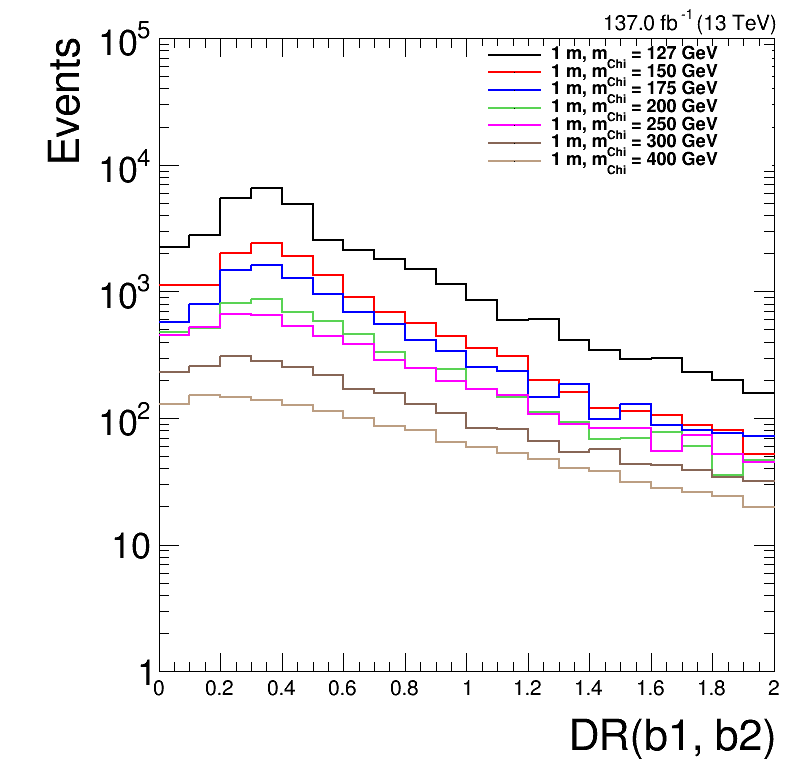

In [54]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    var = []
    evt=0
    for evt in range(len(trg_jet_w[k])):
        etas = trg_llp_grandau_eta[k][evt]
        phis = trg_llp_grandau_phi[k][evt]
        dr1 = DR(etas[0], etas[1], phis[0], phis[1])
        dr2 = DR(etas[2], etas[3], phis[2], phis[3])
        var.append([dr1, dr2])
    var = np.array(var)
    var = var.flatten()
    print(len(var))
    
    ws = trg_jet_w[k]*trg_jet_puw[k]
    ws = np.array([[x,x] for x in ws])
    ws = ws.flatten()
    print(len(ws))
    axis_set = ['DR(b1, b2)', 'Events']
#     bin_set = [40,0,5.0]
#     bin_set = [40,0,1.0]
    bin_set = [20,0,2.0]
    lumi=137000
    
    ht[k] = create_TH1D( var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetRangeUser(1,1e+5)
    print(k, std_color_list[i])
    ht[k].Draw("hist same")
    leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
# outf='llp_grandau_dr_bb.png'
# outf='llp_grandau_dr_bb_1.png'
# outf='llp_grandau_dr_bb_2.png'
outf='llp_grandau_dr_bb_max2_fatjet'+str(fatjet_pt_cut)+'.png'
c.SaveAs(plotDir+outf)    
    

127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
4830
4830
127 1
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
5044
5044
150 2
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
5172
5172
175 4
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
6042
6042
200 8
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
8564
8564
250 6
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
12290
12290
300 28
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
21988
21988
400 43
137.0 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/llp_grandau_dr_bb_max2_fatjet0_shape.png has been created


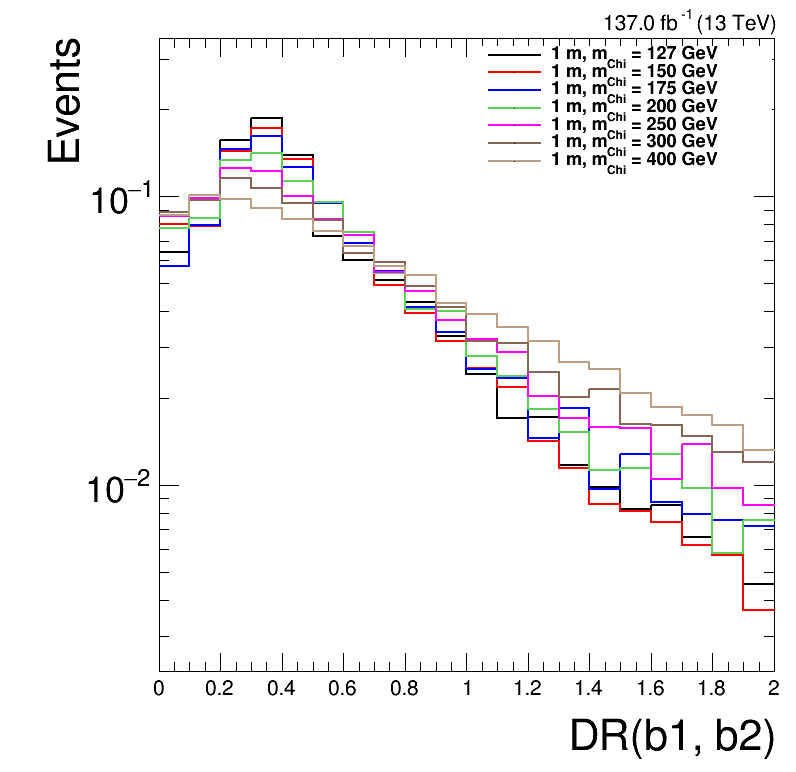

In [55]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    var = []
    evt=0
    for evt in range(len(trg_jet_w[k])):
        etas = trg_llp_grandau_eta[k][evt]
        phis = trg_llp_grandau_phi[k][evt]
        dr1 = DR(etas[0], etas[1], phis[0], phis[1])
        dr2 = DR(etas[2], etas[3], phis[2], phis[3])
        var.append([dr1, dr2])
    var = np.array(var)
    var = var.flatten()
    print(len(var))
    
    ws = trg_jet_w[k]*trg_jet_puw[k]
    ws = np.array([[x,x] for x in ws])
    ws = ws.flatten()
    print(len(ws))
    axis_set = ['DR(b1, b2)', 'Events']
#     bin_set = [40,0,5.0]
    bin_set = [20,0,2.0]
    lumi=137000
    
    ht[k] = create_TH1D( var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
#     ht[k].GetYaxis().SetRangeUser(1,1e+5)
    print(k, std_color_list[i])
    ht[k].DrawNormalized("hist same")
    leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
# outf='llp_grandau_dr_bb_shape.png'
# outf='llp_grandau_dr_bb_2_shape.png'
outf='llp_grandau_dr_bb_max2_fatjet'+str(fatjet_pt_cut)+'_shape.png'
c.SaveAs(plotDir+outf)    
    

127 <TTree b'SusyLLPTree' at 0x7fa39935fc88>
4830
4830
4830
4830
4830
127 1
137.0 fb^{-1} (13 TeV)
127
150 <TTree b'SusyLLPTree' at 0x7fa39915d0b8>
5044
5044
5044
5044
5044
150 2
137.0 fb^{-1} (13 TeV)
150
175 <TTree b'SusyLLPTree' at 0x7fa393009208>
5172
5172
5172
5172
5172
175 4
137.0 fb^{-1} (13 TeV)
175
200 <TTree b'SusyLLPTree' at 0x7fa392cd98d0>
6042
6042
6042
6042
6042
200 8
137.0 fb^{-1} (13 TeV)
200
250 <TTree b'SusyLLPTree' at 0x7fa3928934e0>
8564
8564
8564
8564
8564
250 6
137.0 fb^{-1} (13 TeV)
250
300 <TTree b'SusyLLPTree' at 0x7fa392343b38>
12290
12290
12290
12290
12290
300 28
137.0 fb^{-1} (13 TeV)
300
400 <TTree b'SusyLLPTree' at 0x7fa391b4dc50>
21988
21988
21988
21988
21988
400 43
137.0 fb^{-1} (13 TeV)
400


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/2D_DRbb_HPt_mass127.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/2D_DRbb_HPt_mass150.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/2D_DRbb_HPt_mass175.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/2D_DRbb_HPt_mass200.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20201005/boosted/0/2D_DRbb_HPt

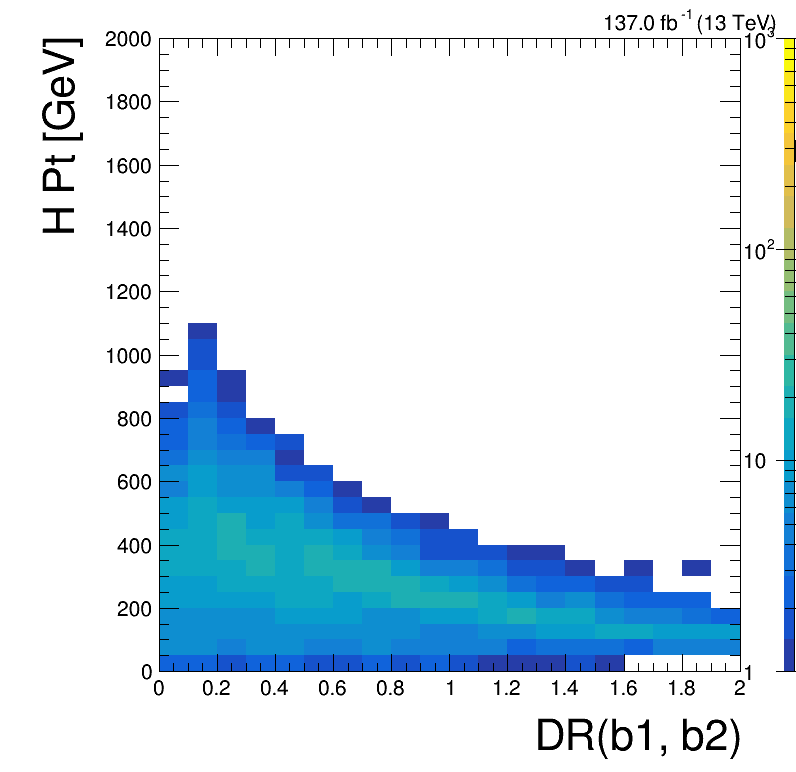

In [62]:
# Plotting  
from ROOT import gStyle
from ROOT import gROOT
from ROOT import TStyle

gROOT.SetBatch(1)
gStyle.SetPaintTextFormat(".2f")
gStyle.SetOptStat(0)
# gStyle.SetOptStat(1111)



color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    c = rt.TCanvas('c','c', 800, 800)
    ht = {}
    leg = rt.TLegend(0.60,0.78,0.97,0.94)

    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)

    var = []
    evt=0
    for evt in range(len(trg_jet_w[k])):
        etas = trg_llp_grandau_eta[k][evt]
        phis = trg_llp_grandau_phi[k][evt]
        dr1 = DR(etas[0], etas[1], phis[0], phis[1])
        dr2 = DR(etas[2], etas[3], phis[2], phis[3])
        var.append([dr1, dr2])
    var = np.array(var)
    var = var.flatten()
    print(len(var))
    
    
    axis_set = ['DR(b1, b2)', 'H Pt [GeV]','Events']
    bin_set = [20,0,2.0,40,0,2000]
    lumi=137000
    
    
    h_str = np.logical_and(1, abs(trg_llp_dau_id[k])==25)
    var_y = trg_llp_dau_pt[k][h_str]
    
    ws = trg_jet_w[k]*trg_jet_puw[k]
    ws = np.array([[x,x] for x in ws])
    ws = ws.flatten()
    
    print(len(var))
    print(len(var_y))
    print(len(ws))
    
   
    
    var_xy = np.transpose(np.row_stack((var, var_y)))
    
    print(len(var_xy))
    
    ht[k] = create_TH2D( var_xy, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
#     ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetLabelSize(0.03)
    ht[k].GetZaxis().SetLabelSize(0.03)
    ht[k].GetZaxis().SetLabelOffset(-0.07)
    ht[k].GetZaxis().SetTitleOffset(0.)
#     ht[k].GetZaxis().SetRangeUser(1,1e+5)
    ht[k].SetMinimum(1)
    ht[k].SetMaximum(1e+3)
#     ht[k].GetYaxis().SetRangeUser(1,1e+5)
    print(k, std_color_list[i])
#     ht[k].Draw("COLZ surf1zfb ")
    ht[k].Draw("COLZ")
#     ht[k].Draw("cont3 same")
#     leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
    CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,3)

    # leg.Draw()
    c.SetLeftMargin(0.2)
    c.SetRightMargin(0.07)
    # c.SetLogy()
    c.SetLogz()
    c.Draw()
    print(k)
    outf='2D_DRbb_HPt_mass'+str(k)+'.png'
    c.SaveAs(plotDir+outf)    
    

# Tags

In [19]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
#     print(trg_jet_pt[k][:10])
#     print(tag_jet_pt[k][:10])
#     print(untag_jet_pt[k][:10])
    
#     print(np.unique(nJets[k]))
#     print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
#     print(len(trg_jet_w[k]))
#     print(len(trg_jet_w[k][nTags[k]==0]))
#     print(len(trg_jet_w[k][nTags[k]==1]))
#     print('count')
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     print(np.sum(trg_jet_w[k]))
#     print(np.sum(trg_jet_w[k][nTags[k]==0]))
#     print(np.sum(trg_jet_w[k][nTags[k]==1]))
#     print('weight sum')
#     print(np.sum(trg_jet_w[k][nTags[k]==2]))
#     print('weight sum * 137 fb-1')
#     print(round(np.sum(trg_jet_w[k][nTags[k]==2])*137000,2),' +/- ',round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*137000),2))
#     print('[weight*pu reweight] sum * 137 fb-1')
#     print(round(np.sum(trg_jet_w[k][nTags[k]==2]*trg_jet_puw[k][nTags[k]==2])*137000,2), ' +/- ',round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2]*trg_jet_puw[k][nTags[k]==2])*137000),2))
#     print(len(trg_jet_puw[k][nTags[k]==2]))
    

127 <TTree b'SusyLLPTree' at 0x7fdd365cf860>
[0 1 2]
150 <TTree b'SusyLLPTree' at 0x7fdd3636ca58>
[0 1 2]
175 <TTree b'SusyLLPTree' at 0x7fdd352ac278>
[0 1 2 3]
200 <TTree b'SusyLLPTree' at 0x7fdd351dcf60>
[0 1 2 3]
250 <TTree b'SusyLLPTree' at 0x7fdd2ee4e4e0>
[0 1 2 3]
300 <TTree b'SusyLLPTree' at 0x7fdd2e9a2208>
[0 1 2 3 4]
400 <TTree b'SusyLLPTree' at 0x7fdd2e941f98>
[0 1 2 3 4]


In [25]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'All Jet Yield', 'All Jet Error',  'Tag Yield', 'Tag Error', 'Tag Eff'])
for k,v in tree.items():
 
    lumi=137000
    EventW = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])]
    JetW = [x*y for x,y in zip(EventW, trg_jet_pt[k].count())]
    TagW = [x*y for x,y in zip(EventW, nTags[k])]
    EventWsq = [x*x  for x in  EventW]
    JetWsq = [x*x*y*y  for x,y in zip(EventW, trg_jet_pt[k].count())]
    TagWsq = [x*x*y*y  for x,y in zip(EventW, nTags[k])]
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(JetW)*lumi, 2), round(math.sqrt(np.sum(JetWsq))*lumi, 2), round(np.sum(TagW)*lumi, 2), round(math.sqrt(np.sum(TagWsq))*lumi, 2), round(np.sum(TagW)/np.sum(JetW), 2) ]
    table.add_row(row)
        
print(table)    



======================= Summary ==============================
+--------+-----------------+---------------+---------------+-----------+-----------+---------+
| Sample |      Weight     | All Jet Yield | All Jet Error | Tag Yield | Tag Error | Tag Eff |
+--------+-----------------+---------------+---------------+-----------+-----------+---------+
|  127   | [5.6951445e-05] |    28821.26   |     779.03    |  5235.28  |   238.42  |   0.18  |
|  150   | [2.1877613e-05] |    12668.89   |     330.03    |  2469.23  |   101.2   |   0.19  |
|  175   | [1.5398517e-05] |    9793.14    |     253.16    |  1883.42  |   76.41   |   0.19  |
|  200   |  [8.116029e-06] |    6369.04    |     149.78    |   1416.8  |   47.94   |   0.22  |
|  250   | [5.1101733e-06] |    6264.47    |     122.39    |  1444.43  |   39.54   |   0.23  |
|  300   | [1.8683509e-06] |    3562.46    |     56.72     |   930.92  |    20.0   |   0.26  |
|  400   |  [6.086827e-07] |    2232.16    |     25.93     |   618.89  |    9.44

In [27]:
table_txt = table.get_string()
 
with open(plotDir+'/TagEffSummaryTablePerJet.txt','w') as file:
 
    file.write(table_txt)

In [28]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Per Jet Tag Eff'])
for k,v in tree.items():
 
    lumi=137000
    EventW = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])]
    JetW = [x*y for x,y in zip(EventW, trg_jet_pt[k].count())]
    TagW = [x*y for x,y in zip(EventW, nTags[k])]
    EventWsq = [x*x  for x in  EventW]
    JetWsq = [x*x*y*y  for x,y in zip(EventW, trg_jet_pt[k].count())]
    TagWsq = [x*x*y*y  for x,y in zip(EventW, nTags[k])]
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    row = [k,  round(np.sum(TagW)/np.sum(JetW), 2) ]
    table.add_row(row)
        
print(table)    



======================= Summary ==============================
+--------+-----------------+
| Sample | Per Jet Tag Eff |
+--------+-----------------+
|  127   |       0.18      |
|  150   |       0.19      |
|  175   |       0.19      |
|  200   |       0.22      |
|  250   |       0.23      |
|  300   |       0.26      |
|  400   |       0.28      |
+--------+-----------------+


127 <TTree b'SusyLLPTree' at 0x7fdd388c1160>
127 1
150 <TTree b'SusyLLPTree' at 0x7fdd3863d2b0>
150 2
175 <TTree b'SusyLLPTree' at 0x7fdd3836cd68>
175 4
200 <TTree b'SusyLLPTree' at 0x7fdd38066ba8>
200 8
250 <TTree b'SusyLLPTree' at 0x7fdd37cc7128>
250 6
300 <TTree b'SusyLLPTree' at 0x7fdd37834e48>
300 28
400 <TTree b'SusyLLPTree' at 0x7fdd3710ac18>
400 43
137.0 fb^{-1} (13 TeV)


Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200923/nTags.png has been created


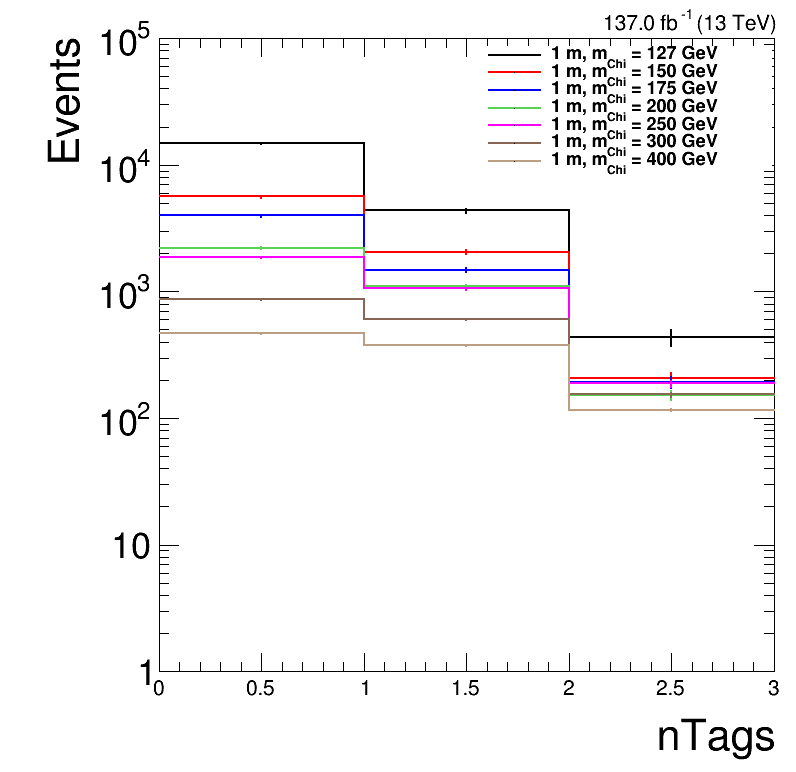

In [7]:
# Plotting  
c = rt.TCanvas('c','c', 800, 800)
ht = {}
leg = rt.TLegend(0.60,0.78,0.97,0.94)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


color_list = [845,806,861,876,597,625]

i=0
for k,v in tree.items():
    print(k,v)
    
    var = nTags[k]
    ws = trg_jet_w[k]*trg_jet_puw[k]
    axis_set = ['nTags', 'Events']
    bin_set = [3,0,3]
    lumi=137000
    
    ht[k] = create_TH1D( var, axis_title=axis_set, name=k, binning=bin_set,weights = ws*lumi)
    ht[k].SetLineColor(std_color_list[i])
    ht[k].GetXaxis().SetLabelSize(0.03)
    ht[k].GetYaxis().SetRangeUser(1,1e+5)
    print(k, std_color_list[i])
    ht[k].Draw("hist E same")
    leg.AddEntry(ht[k],'1 m, m_{Chi} = '+k+' GeV')  
    
    i+=1
    
CMS_lumi.lumi_13TeV = str(lumi/1000)+" fb^{-1}"
CMS_lumi.cmsText = ""
CMS_lumi.writeExtraText = False
CMS_lumi.CMS_lumi(c,4,3)

leg.Draw()
c.SetLeftMargin(0.2)
c.SetRightMargin(0.027)
c.SetLogy()
c.Draw()
outf='nTags.png'
c.SaveAs(plotDir+outf)    
    

# Signal Yields

In [8]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Weight' , 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
#     if '2016' in k:
#         lumi=35922
#     elif '2017' in k:
#         lumi=41529
#     elif '2018' in k:
#         lumi=59740
    lumi=137000
#     print(k)
#     EventW =  trg_jet_w[k][nTags[k]==2] 
    EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==2],trg_jet_puw[k][nTags[k]==2])]
#     EventW = [x*y for x,y in zip(trg_jet_w[k],trg_jet_puw[k])]
    EventWsq = [x*x  for x in EventW]
#     print(np.sum(EventW)*lumi)
    print(np.sum(EventW)*1)
#     print(len(EventW))
#     print(len(trg_jet_w[k][nTags[k]==2]))
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(trg_jet_w[k][nTags[k]==2])*lumi, 2), round(math.sqrt(np.sum(trg_jet_w[k][nTags[k]==2])*lumi), 2) ]
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventW)*lumi), 2) ]
    row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
0.003194227581843734
0.0014963079011067748
0.0014129193732514977
0.001117353094741702
0.001375426771119237
0.0011197470594197512
0.0008496969239786267
+--------+-----------------+-------------+-------------+
| Sample |      Weight     | Bin 2 Yield | Bin 2 Error |
+--------+-----------------+-------------+-------------+
|  127   | [5.6951445e-05] |    437.61   |     64.5    |
|  150   | [2.1877613e-05] |    204.99   |    27.09    |
|  175   | [1.5398517e-05] |    193.57   |    22.12    |
|  200   |  [8.116029e-06] |    153.08   |    14.24    |
|  250   | [5.1101733e-06] |    188.43   |    12.58    |
|  300   | [1.8683509e-06] |    153.41   |     6.86    |
|  400   |  [6.086827e-07] |    116.41   |     3.38    |
+--------+-----------------+-------------+-------------+


In [9]:
table_txt = table.get_string()
# with open(plotDir+'/467SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/310SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/1m_200GeV_467SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/10m_200GeV_467SignalSummaryTableBin2Rebin.txt','w') as file:
with open(plotDir+'/SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/Resolved_fatjet250_SignalSummaryTableBin2Rebin.txt','w') as file:
# with open(plotDir+'/Resolved_fatjet300_SignalSummaryTableBin2Rebin.txt','w') as file:
    file.write(table_txt)

In [10]:
# from prettytable import PrettyTable
# print('\n\n======================= Summary ==============================')
# table =  PrettyTable(['Sample', 'Weight' , 'AK8 Yield', 'AK8 Error'])
# for k,v in tree.items():
 
#     lumi=137000
 
#     EventW = [x*y for x,y in zip(trg_jet_w[k][trg_fatjet_pt[k].count()>0],trg_jet_puw[k][trg_fatjet_pt[k].count()>0])]
# #     EventW = [x*y for x,y in zip(trg_jet_w[k][trg_fatjet_pt[k].count()==0],trg_jet_puw[k][trg_fatjet_pt[k].count()==0])]
#     EventWsq = [x*x  for x in EventW]
#     row = [k, np.unique(trg_jet_w[k]) ,round(np.sum(EventW)*lumi, 2), round(math.sqrt(np.sum(EventWsq))*lumi, 2) ]
#     table.add_row(row)
        
# print(table)

In [11]:
# table_txt = table.get_string()
# with open(plotDir+'/Boosted_fatjet250_SignalSummaryTableBin2Rebin.txt','w') as file:
# # with open(plotDir+'/Boosted_fatjet300_SignalSummaryTableBin2Rebin.txt','w') as file:
#     file.write(table_txt)

# Check on Reweight

In [34]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**2
    weight = 1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight

In [43]:
# OLD_CTAU=10000 #mm
# ctaus=np.array([1000])

OLD_CTAU=1000 #mm
ctaus=np.array([10000])

EventReW = {}
for k,v in tree.items():
    print(k)
    if len(trg_jet_ctau[k]) == 0: continue
    EventReW[k] = {}
    for ct in ctaus: 
        print('ctau', ct, ' mm')
        EventW = [x*y for x,y in zip(trg_jet_w[k][nTags[k]==2],trg_jet_puw[k][nTags[k]==2])]
        ctau_calc = np.array([x[0]+x[1] for x in trg_jet_ctau[k][nTags[k]==2] ])
        weight_ctau = weight_calc( ctau_calc, float(ct)/10, OLD_CTAU/10) # convert everything to cm
        EventReW[k][ct] =  trg_jet_w[k][nTags[k]==2]*weight_ctau*trg_jet_puw[k][nTags[k]==2]


200
ctau 10000  mm


In [44]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Ctau [mm]', 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
    lumi=137000
    for ct in ctaus:
        row = [k, ct, round(np.sum(EventReW[k][ct])*lumi, 2), round(math.sqrt(np.sum(EventReW[k][ct])*lumi), 2) ]
        table.add_row(row)
        
print(table)



======================= Summary ==============================
+--------+-----------+-------------+-------------+
| Sample | Ctau [mm] | Bin 2 Yield | Bin 2 Error |
+--------+-----------+-------------+-------------+
|  200   |   10000   |    16.79    |     4.1     |
+--------+-----------+-------------+-------------+


In [45]:
table_txt = table.get_string()
# with open(plotDir+'/1m_Reweight_200_CTAUSignalSummaryTableBin2Rebin.txt','w') as file:
with open(plotDir+'/10m_Reweight_200_CTAUSignalSummaryTableBin2Rebin.txt','w') as file:
    file.write(table_txt)